In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [2]:
#pip install pmdarima

In [3]:
#pip install mpl_interactions["jupyter"] 

In [130]:
spall = pd.read_csv('../data/sp500_cleaned-final.csv', low_memory=False,parse_dates=['Date'])
sp=spall

In [131]:
#Global variables
date_Filter = '2019-01-01'

In [132]:
sp

,Date,Open,High,Low,Close
0,1927-12-30,17.66,17.66,17.66,17.66
1,1928-01-03,17.76,17.76,17.76,17.76
2,1928-01-04,17.72,17.72,17.72,17.72
3,1928-01-05,17.55,17.55,17.55,17.55
4,1928-01-06,17.66,17.66,17.66,17.66
...,...,...,...,...,...
23953,2023-05-12,4138.54,4143.74,4099.12,4124.08
23954,2023-05-15,4126.65,4141.25,4110.27,4136.28
23955,2023-05-16,4127.95,4135.54,4109.86,4109.90
23956,2023-05-17,4122.85,4164.67,4113.62,4158.77


In [124]:
plot_font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

# Functions used

In [7]:
#MAPE - will be used to measure the performance of the model
#https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
#The lower the MAPE value, the better the forecasting model performance.

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
#Create dataframe from test and Pred
def getTestPredDF(test_df, pred_df):
    cols = ['date', 'y_test', 'y_pred']
    res_df=pd.DataFrame(data=[test_df.index.to_numpy(),test_df["Close"].to_numpy(), pred_df]).T
    res_df.columns = cols
    return res_df    

In [9]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
                    
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse 
#             })

    df_acc = pd.DataFrame(columns = ['mape', 'me', 'mae','mpe','rmse'])
    df_acc["mape"] = [mape]
    df_acc["me"] = [me]
    df_acc["mae"] = [mae]
    df_acc["mpe"] = [mpe]
    df_acc["rmse"] = [rmse]
    
    return df_acc

# Rolling Forecast ARIMA Model

In [188]:
# This function fits the ARIMA model
# parameters
# dfSP: S&P500 dataframe
# pdq: P, D and q parameters for AR, I and Ma component of ARIMA model e.g.(5,1,1)
# train_perc: training percentage (e.g, .9( 90% for dataframe))
    
from math import sqrt
def ARIMA_model_fit_plot(dfSP, pdq, train_perc):
    dates = dfSP.index.to_numpy()
    X = dfSP.values
    size = int(len(X) * train_perc)
    train, test, test_dates = X[0:size], X[size:len(X)], dates[size:len(X)]
    history = [x for x in train]
    predictions = list()
    


    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(pdq))
        model_fit = model.fit()
        output = model_fit.forecast()
        y_pred = output[0]
        predictions.append(y_pred)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (y_pred, obs))
    
    #forecast accuracy 
    print("Accuracy Metrics:")        
    acc = forecast_accuracy(predictions, test)
    print(acc)

    ##plot forecasts against actual outcomes
    # plt.plot(test)
    # plt.plot(predictions, color='orange')
    # plt.show()

    #Plot Test VS predicted, Future
   
    pTitle = "ARIMA Plot p,d,q = {} ".format(pdq)
    plt.figure(figsize=(18,10))
    plt.plot(test_dates , test, label="original" )
    plt.plot(test_dates , predictions, label="predicted" )
    plt.xticks(rotation=70)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price',fontsize=18)
    plt.title(pTitle, fontdict=plot_font)
    plt.legend()
    plt.show()

    return train, test, predictions, acc

In [133]:
# SP500
#Filter the SP data 
sp = sp[sp['Date'] > date_Filter]
sp = sp.drop(['Open','High','Low'], axis=1).sort_values(by='Date',ascending=True) 
# Scale Close price
#sp[['Close']] = scaler.fit_transform(sp[['Close']])
print(sp)


            Date    Close
22855 2019-01-02  2510.03
22856 2019-01-03  2447.89
22857 2019-01-04  2531.94
22858 2019-01-07  2549.69
22859 2019-01-08  2574.41
...          ...      ...
23953 2023-05-12  4124.08
23954 2023-05-15  4136.28
23955 2023-05-16  4109.90
23956 2023-05-17  4158.77
23957 2023-05-18  4198.05

[1103 rows x 2 columns]


In [134]:
sp.index = sp.pop('Date')
sp

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2023-05-12,4124.08
2023-05-15,4136.28
2023-05-16,4109.90


In [135]:
df=sp
df

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2023-05-12,4124.08
2023-05-15,4136.28
2023-05-16,4109.90


### S&P 500 Price till May 2023

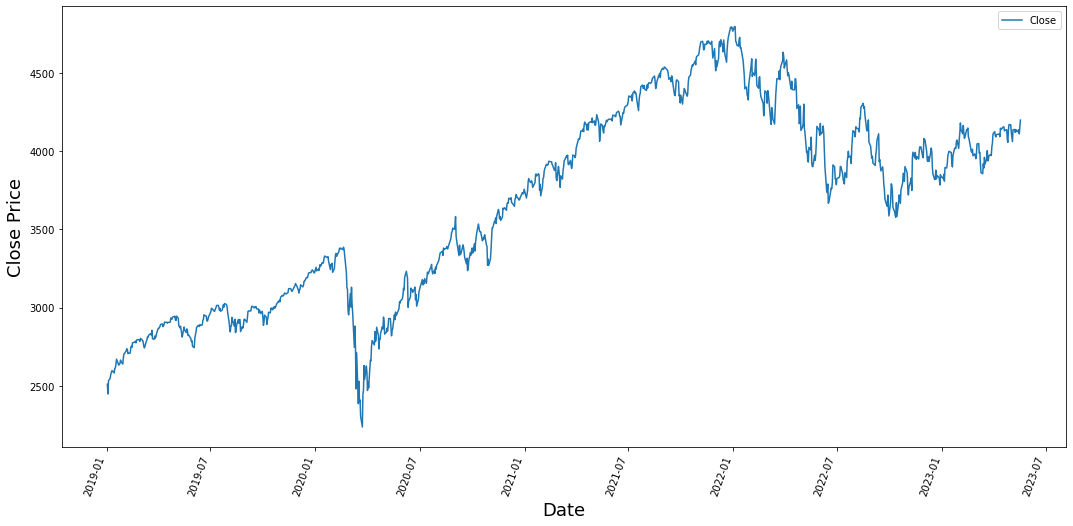

In [13]:
#Plot sp500
sp.plot.line(y="Close", use_index=True, figsize = (18,9))
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()


# ARIMA
short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.




An ARIMA model is characterized by 3 terms: p, d, q where,

p is the order of the AR term 

q is the order of the MA term

d is the number of differencing required to make the time series stationary

## Components of a Time Series:
### Trend:
The trend shows a general direction of the time series data over a long period of time. A trend can be increasing(upward), decreasing(downward), or horizontal(stationary).
### Seasonality:
The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions, or an increase in the number of airline passengers during holidays each year.
### Cyclical Component: 
These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.
### Irregular Variation: 
These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.
### ETS Decomposition
ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend, and Seasonality.

### Stationarity check of S&P 500


In [14]:
#Seasonal component
#The seasonal component explains the periodic ups and downs 

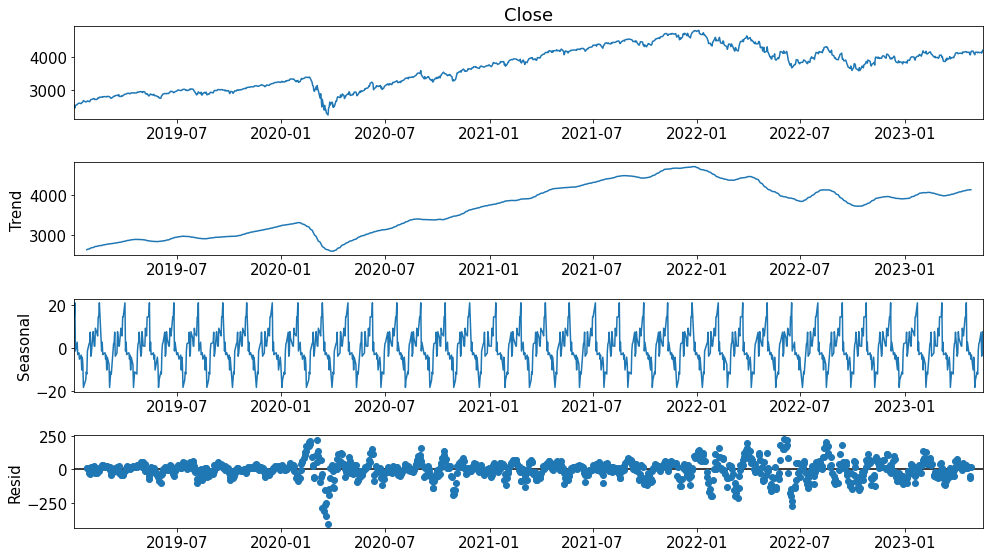

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(sp.Close,model='additive', period=30)
fig = result.plot()


### Points:

Monthly seasonal pattern is visible
An upwards,downwards, and sideways trend is evident

### Augmented Dickey Fuller (ADFuller) Test

In [16]:
#Lets perform ADFuller test to check if the series is stationary
from statsmodels.tsa.stattools import adfuller

def adfuller_test(dataset):
  adfresult = adfuller(dataset, autolag = 'AIC')
  print("1. ADF Statistic: ",adfresult[0])
  print("2. p-value : ", adfresult[1])
  print("3. Num Of Lags : ", adfresult[2])
  print("4. Num Of Observations :", adfresult[3])
  print("5. Critical Values :")
  for key, val in adfresult[4].items():
      print("\t",key, ": ", val)

In [17]:
adfuller_test(df['Close'])

1. ADF Statistic:  -1.6369014959425516
2. p-value :  0.4638803057763014
3. Num Of Lags :  10
4. Num Of Observations : 1092
5. Critical Values :
	 1% :  -3.436352507699052
	 5% :  -2.86419037625175
	 10% :  -2.56818114683546


#### The output above shows that the p-value is greater than the significance level of 0.05, so we fail to reject the null hypothesis. The series is not stationary and requires differencing.
let’s difference the series and see how the autocorrelation plot looks like.

In [18]:
diff_1 = df['Close'].diff().dropna()
print("p-value:", adfuller(diff_1.dropna())[1])

p-value: 7.457834290526893e-18


### The p-value is now below the significance level, indicating that the series is stationary.

In [19]:
# import numpy as np, pandas as pd
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# spadf = spall[spall['Date'] > '2020-01-01']
# spadf = spadf.drop(['Open','High','Low'], axis=1).sort_values(by='Date',ascending=True) 
# spadf.index = spadf.pop('Date')

# # scaler_spadf = MinMaxScaler()
# # spadf[['Close']] = scaler_spadf.fit_transform(spadf[['Close']])
# print(spadf)

# # Original Series
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(spadf['Close']); axes[0, 0].set_title('Original Series')
# plot_acf(spadf['Close'], ax=axes[0, 1],lags=30)

# # 1st Differencing
# axes[1, 0].plot(spadf.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(spadf['Close'].diff().dropna(), ax=axes[1, 1],lags=30)

# # 2nd Differencing
# axes[2, 0].plot(spadf.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(spadf['Close'].diff().diff().dropna(), ax=axes[2, 1],lags=30)

# plt.show()

## ACF and PACF plots

####  The autocorrelation function will show the relationship between a point in time and lagged values

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


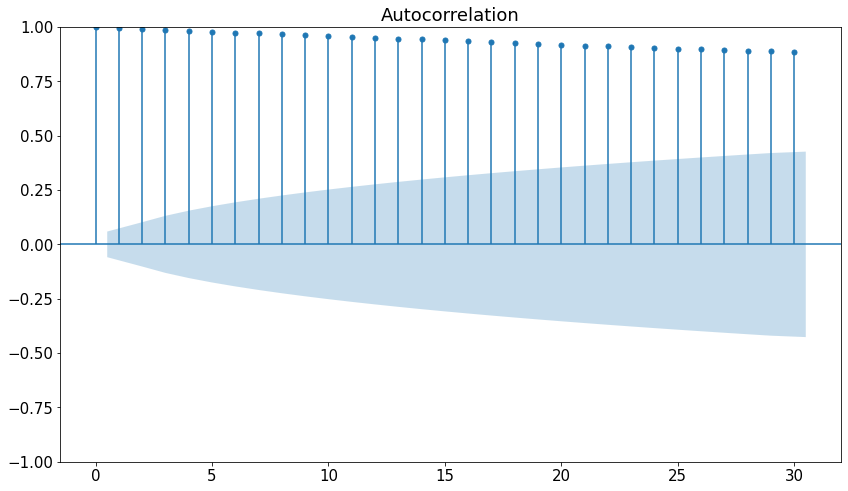

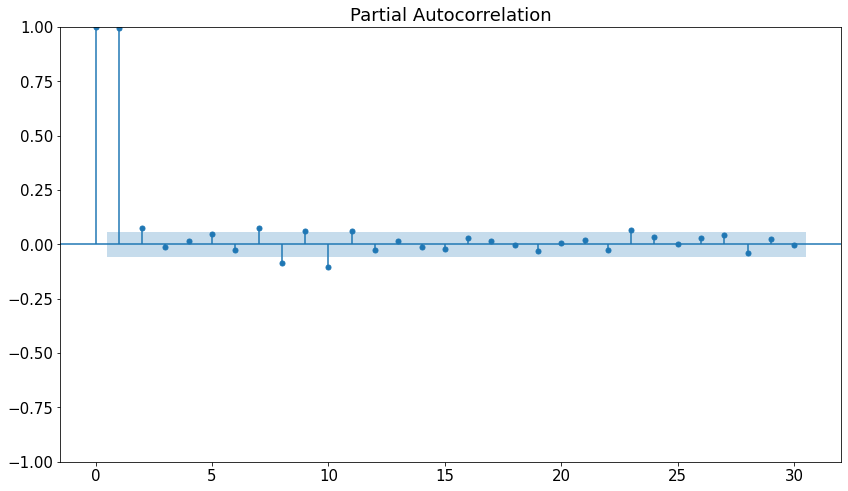

In [20]:
#Original Series
plot_acf(sp['Close'], lags=30);
plot_pacf(sp['Close'], lags=30);

Clearly, the data is not ideal for the ARIMA model to directly start autoregressive training. So let’s see how the differencing segment of ARIMA makes the data stationary.

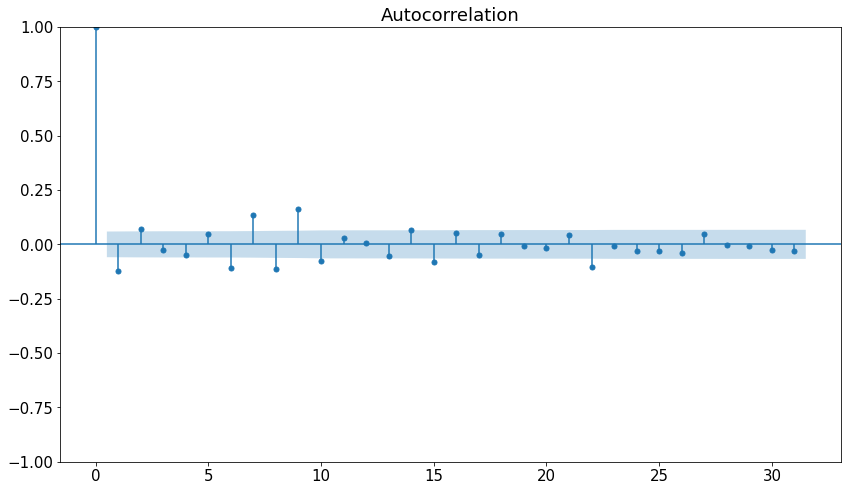

In [21]:
# 1st Differencing
plot_acf(sp['Close'].diff().dropna());

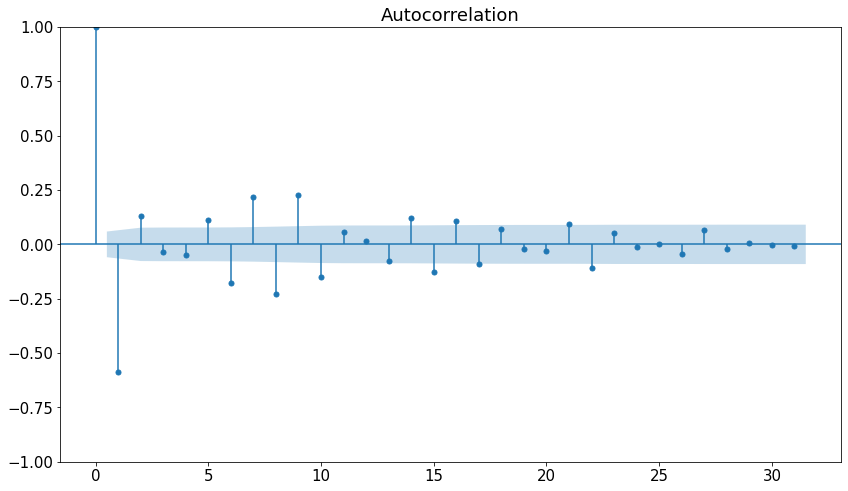

In [22]:
# 2nd Differencing
plot_acf(sp['Close'].diff().diff().dropna());

From the autocorrelation graph, we can decide if more differencing is needed. If collectively the autocorrelations, or the data point of each lag (in the horizontal axis), are positive for several consecutive lags, more differencing might be needed. Conversely, if more data points are negative, the series is over-differenced.

# Estimating AR term(p)

#### In plot above, we see that ACF and PACF results. To estimate the amount of AR terms, we need to look at the PACF plot. First, ignore the value at lag 0. It will always show a perfect correlation, since we are estimating the correlation between today’s value with itself. The blue area in the plot, represents the confidence interval. To estimate how much AR terms we should use, we start counting how many “Pins” are above or below the confidence interval before the next one enter the blue area.

#### So, looking at the PACF(fig 2) plot above, we can estimate to use 2 AR terms for our model, since lag 1 and 2 are out of the confidence interval, and lag 3 is in the blue area.

#  Estimate I(d) term, the order of differencing 
Estimate the amount of I (d) terms is to know how many Differencing was used to make the series stationary. 
For example, if we used log difference or first difference to transform a time series, the amount of I terms will be 1.
Since we diffrentiated 2 times the d=2

# Estimating MA(q) terms
Just like the PACF function, to estimate the amount of MA terms, this time we will look at ACF plot. The same logic is applied here: how much Pins are above or below the confidence interval before the next Pin enters the blue area?

In our example, we can estimate 2 MA terms, since we have lag prior to 2 out of the confidence interval.

# Model 1 - Manual based on ACF PACF
## parameters : p=3, d=1, q=2

# Auto ARIMA to get parameters

In [23]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [24]:
stepwise_fit = auto_arima(df['Close'],trace=True, 
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11573.868, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11634.962, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11619.769, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11621.639, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11634.113, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11619.900, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11620.216, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11575.586, Time=0.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11622.178, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11619.093, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11620.261, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11621.103, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11576.837, Time=0.93 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11573.246, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1103
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5781.623
Date:                Wed, 07 Jun 2023   AIC                          11573.246
Time:                        15:20:56   BIC                          11598.270
Sample:                             0   HQIC                         11582.712
                               - 1103                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7573      0.030    -59.341      0.000      -1.815      -1.699
ar.L2         -0.8836      0.028    -32.015      0.000      -0.938      -0.830
ma.L1          1.6709      0.038     43.494      0.000       1.596       1.746
ma.L2          0.7738      0.036     21.367      0.000       0.703       0.845
sigma2      2110.8034     58.455     36.110      0.000    1996.233    2225.374
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               603.20
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model 2 -  based Auto ARIMA above
## Best model:  ARIMA(2,1,2)(0,0,0)[0] 

# Get Hyper parameters p, d, q for ARIMA

In [25]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
p = range(0,8)
d = range(0,2)
q = range(0,8)

rmse=[]
order=[]
pdq_combination = (list(itertools.product(p,d,q)))
start=len(train)
end=len(train)+len(test)-1

for pdq in pdq_combination:
    try:
        model=ARIMA(train['Close'],order=(pdq))
        model=model.fit()
        s=model.summary() 
        pred=model.predict(start=len(train),end=end)
        error=np.sqrt(mean_squared_error(test,pred))
        order.append(pdq)
        rmse.append(error)

    except Exception as e:
        print(e)
    finally:
        print('pdq: ')
        print(pdq)        
        print('error: ')
        print(error)

NameError: name 'train' is not defined

In [ ]:
cols = ['pdq', 'rmse']
results=pd.DataFrame(data=[order,rmse]).T
results.columns=cols
results
results.to_csv('ARIMA_results.csv')

# Model 3 - based on above loop
#from the csv best parameters, for least MSE are
#105	(6, 1, 1)	116.8841655

# Lets evaluate ARIMA model with above parameters

# Step 1 - Split the data for train and Test

In [26]:
#Split Train and Test data
print(df.shape)
train=df.iloc[:-110]
test=df.iloc[-110:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1103, 1)
(993, 1) (110, 1)
Close    3934.38
Name: 2022-12-09 00:00:00, dtype: float64 Close    4198.05
Name: 2023-05-18 00:00:00, dtype: float64


In [28]:
train

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2022-12-02,4071.70
2022-12-05,3998.84
2022-12-06,3941.26


# Model 1 - Manual

predicted=3923.863008, expected=3963.510000
predicted=3971.642992, expected=3934.380000
predicted=3928.437351, expected=3990.560000
predicted=3992.863083, expected=4019.650000
predicted=4012.832371, expected=3995.320000
predicted=4006.235194, expected=3895.750000
predicted=3893.608387, expected=3852.360000
predicted=3857.683039, expected=3817.660000
predicted=3813.042809, expected=3821.620000
predicted=3825.788316, expected=3878.440000
predicted=3869.311166, expected=3822.390000
predicted=3834.761537, expected=3844.820000
predicted=3835.549917, expected=3829.250000
predicted=3832.926043, expected=3783.220000
predicted=3789.415759, expected=3849.280000
predicted=3834.143981, expected=3839.500000
predicted=3854.046167, expected=3824.140000
predicted=3815.611886, expected=3852.970000
predicted=3854.769898, expected=3808.100000
predicted=3812.333606, expected=3895.080000
predicted=3884.137852, expected=3892.090000
predicted=3898.862926, expected=3919.250000
predicted=3916.855952, expected=

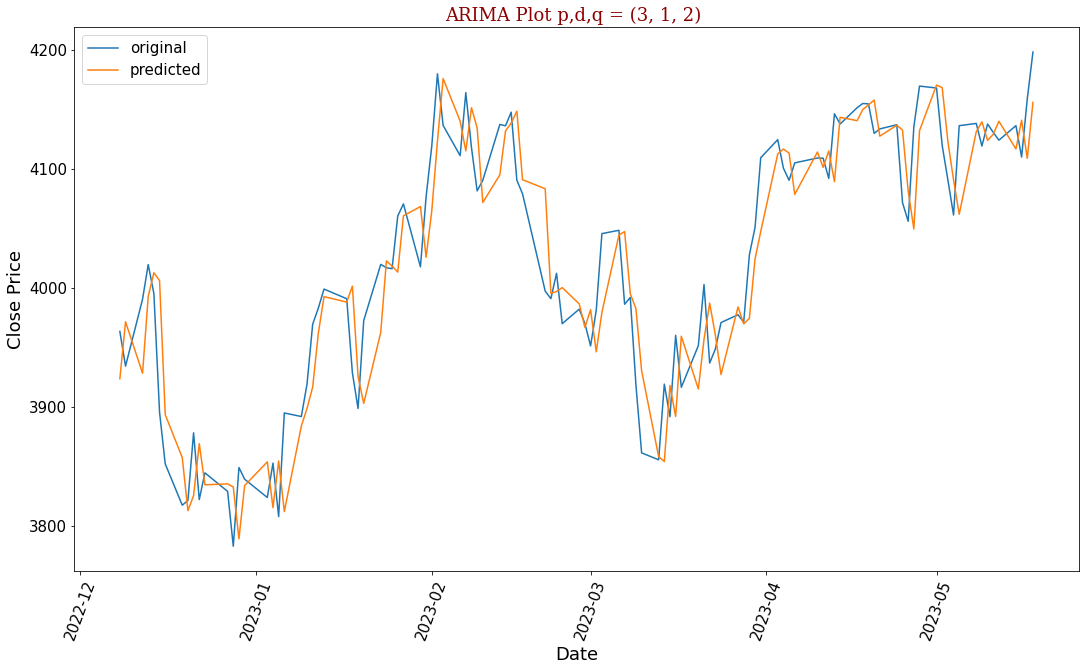

       mape        me         mae       mpe        rmse
0  0.030308 -2.521849  121.378296  0.000088  150.527356


In [190]:
# Use the parameters indenftified manually for Model 1 above
pdq = 3,1,2
train, test, predictions, acc = ARIMA_model_fit_plot(df, pdq, 0.9)
# print(train)
# print(test)
# print(predictions)
print(acc)

In [ ]:
      mape        me         mae      mpe       rmse
0  0.03028 -2.552592  121.266366  0.00008  150.39359

In [ ]:
       mape        me         mae       mpe       rmse
0  0.030257 -2.600314  121.174743  0.000069  150.23487

In [ ]:
       mape        me         mae       mpe        rmse
0  0.030244 -2.567429  121.123133  0.000077  150.193762

In [ ]:
       mape        me         mae       mpe        rmse
0  0.030278 -3.325772  121.269134 -0.000112  150.386825

In [191]:
# # creating a list of column names
# cols = ['date', 'y_test', 'y_pred']
# sp_pred1=pd.DataFrame(data=[test.index.to_numpy(),test["Close"].to_numpy(), predictions1]).T
# sp_pred1.columns = cols
# sp_pred1

# Model 2 -  Auto ARIMA 
## Best model:  ARIMA(2,1,2)(0,0,0)[0] 

predicted=3924.168794, expected=3963.510000
predicted=3970.968622, expected=3934.380000
predicted=3928.727995, expected=3990.560000
predicted=3992.251868, expected=4019.650000
predicted=4011.572073, expected=3995.320000
predicted=4006.277723, expected=3895.750000
predicted=3896.260075, expected=3852.360000
predicted=3859.118801, expected=3817.660000
predicted=3814.496846, expected=3821.620000
predicted=3825.405358, expected=3878.440000
predicted=3868.742821, expected=3822.390000
predicted=3834.279627, expected=3844.820000
predicted=3837.019279, expected=3829.250000
predicted=3831.923854, expected=3783.220000
predicted=3790.931131, expected=3849.280000
predicted=3833.628819, expected=3839.500000
predicted=3852.731543, expected=3824.140000
predicted=3816.713192, expected=3852.970000
predicted=3854.304254, expected=3808.100000
predicted=3812.406491, expected=3895.080000
predicted=3883.858628, expected=3892.090000
predicted=3897.236866, expected=3919.250000
predicted=3916.949107, expected=

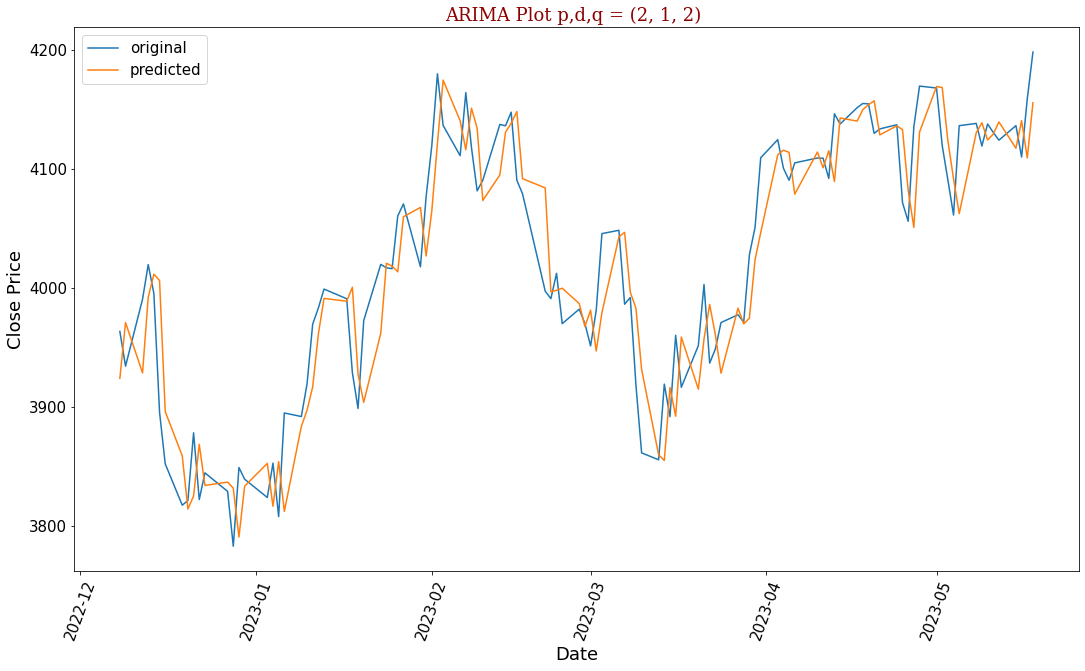

      mape        me         mae      mpe       rmse
0  0.03028 -2.552592  121.266366  0.00008  150.39359


In [197]:
# Use the parameters indenftified manually for Model 1 above
pdq = 2,1,2
train, test, predictions, acc = ARIMA_model_fit_plot(df, pdq, 0.9)
# print(train)
# print(test)
# print(predictions)
print(acc)

# Model 3 - based on the loop
#### (6, 1, 1)	116.8841655

predicted=3922.076102, expected=3963.510000
predicted=3972.137828, expected=3934.380000
predicted=3932.882150, expected=3990.560000
predicted=3996.527011, expected=4019.650000
predicted=4014.648189, expected=3995.320000
predicted=4004.473871, expected=3895.750000
predicted=3893.089789, expected=3852.360000
predicted=3860.505497, expected=3817.660000
predicted=3807.168713, expected=3821.620000
predicted=3831.021593, expected=3878.440000
predicted=3871.452530, expected=3822.390000
predicted=3843.823894, expected=3844.820000
predicted=3833.919111, expected=3829.250000
predicted=3837.057433, expected=3783.220000
predicted=3784.115584, expected=3849.280000
predicted=3837.235703, expected=3839.500000
predicted=3852.739116, expected=3824.140000
predicted=3818.153686, expected=3852.970000
predicted=3853.580274, expected=3808.100000
predicted=3814.503797, expected=3895.080000
predicted=3879.386604, expected=3892.090000
predicted=3900.258527, expected=3919.250000
predicted=3917.335218, expected=

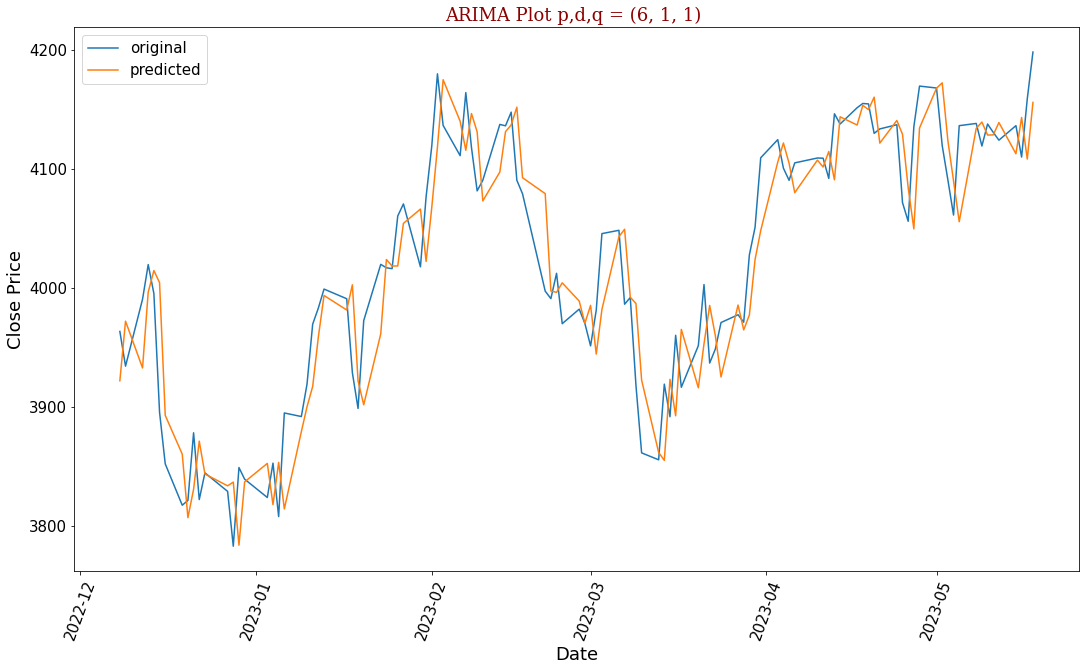

       mape        me         mae       mpe       rmse
0  0.030257 -2.600314  121.174743  0.000069  150.23487


In [198]:
# Use the parameters indenftified manually for Model 1 above
pdq = 6,1,1
train, test, predictions, acc = ARIMA_model_fit_plot(df, pdq, 0.9)
# print(train)
# print(test)
# print(predictions)
print(acc)

# Model 4 Updated

In [194]:

dates = df.index.to_numpy()
X = df.values
size = int(len(X) * 0.9)
train, test , test_dates= X[0:size], X[size:len(X)], dates[size:len(X)]
history = [x for x in train]
predictions = list()

len(test)

111

In [196]:
# walk-forward validation
pqr = 2,1,2
for t in range(len(test)):
    model = ARIMA(history, order=(pqr))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
from math import sqrt
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()


#Plot Test VS predicted, Future
plt.figure(figsize=(18,10))
plt.plot(test_dates , test, label="original" )
plt.plot(test_dates , predictions, label="predicted" )
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)


plt.legend()
plt.show()

    
dfx = pd.DataFrame(columns = ['mape', 'me', 'mae','mpe','rmse'])
dfx["mape"] = [11]
dfx["me"] = [22]
dfx["mae"] = [33]
dfx["mpe"] = [44]
dfx["rmse"] = [55]

predicted=4195.270323, expected=3963.510000
predicted=3986.765369, expected=3934.380000
predicted=3926.641062, expected=3990.560000
predicted=3984.403337, expected=4019.650000
predicted=4027.350867, expected=3995.320000
predicted=3986.096625, expected=3895.750000
predicted=3916.168907, expected=3852.360000
predicted=3839.650543, expected=3817.660000
predicted=3830.639740, expected=3821.620000
predicted=3813.081299, expected=3878.440000
predicted=3877.599677, expected=3822.390000
predicted=3829.077741, expected=3844.820000
predicted=3838.391593, expected=3829.250000
predicted=3833.708246, expected=3783.220000
predicted=3786.303184, expected=3849.280000
predicted=3840.062044, expected=3839.500000
predicted=3846.114306, expected=3824.140000
predicted=3822.522857, expected=3852.970000
predicted=3849.887129, expected=3808.100000
predicted=3815.083575, expected=3895.080000
predicted=3883.397833, expected=3892.090000
predicted=3897.142795, expected=3919.250000
predicted=3917.880045, expected=

ValueError: Found input variables with inconsistent numbers of samples: [111, 222]

predicted=3923.113945, expected=3963.510000
predicted=3970.421657, expected=3934.380000
predicted=3930.764415, expected=3990.560000
predicted=4001.282948, expected=4019.650000
predicted=4013.236364, expected=3995.320000
predicted=4003.740003, expected=3895.750000
predicted=3894.185400, expected=3852.360000
predicted=3857.899840, expected=3817.660000
predicted=3811.038129, expected=3821.620000
predicted=3829.431690, expected=3878.440000
predicted=3875.020627, expected=3822.390000
predicted=3839.803177, expected=3844.820000
predicted=3836.530971, expected=3829.250000
predicted=3833.168818, expected=3783.220000
predicted=3782.366247, expected=3849.280000
predicted=3837.202781, expected=3839.500000
predicted=3854.440507, expected=3824.140000
predicted=3816.012148, expected=3852.970000
predicted=3859.143446, expected=3808.100000
predicted=3808.476394, expected=3895.080000
predicted=3881.980692, expected=3892.090000
predicted=3899.428210, expected=3919.250000
predicted=3914.598209, expected=

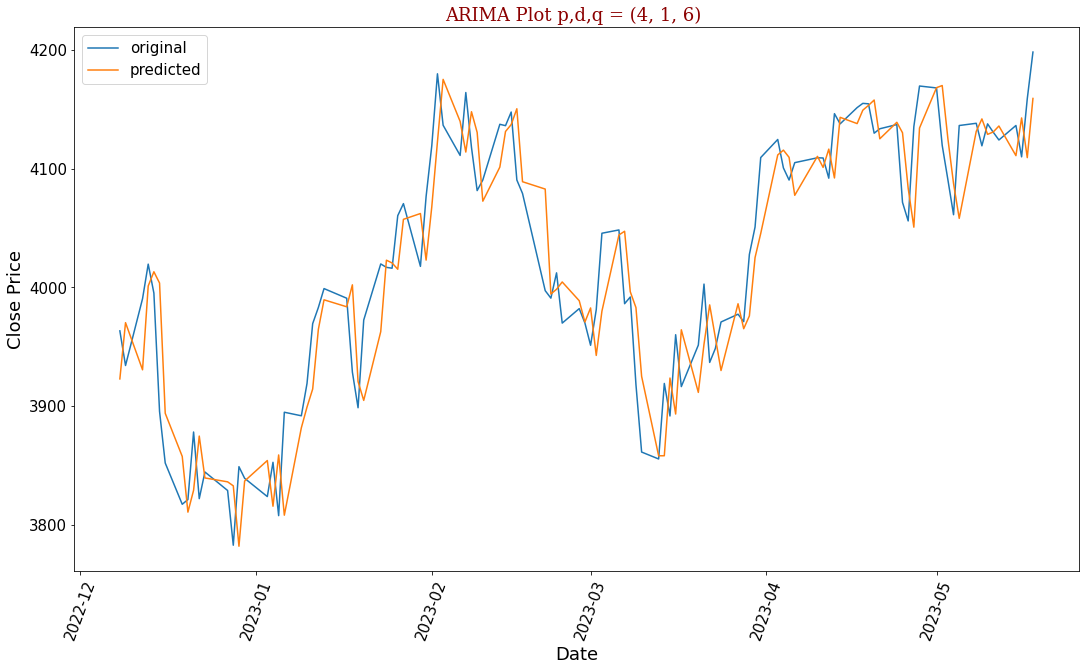

       mape       me         mae       mpe        rmse
0  0.030273 -2.53505  121.239249  0.000085  150.337491


In [200]:
pdq = 4,1,6
train, test, predictions, acc = ARIMA_model_fit_plot(df, pdq, 0.9)
# print(train)
# print(test)
# print(predictions)
print(acc)

In [58]:
test

array([[3963.51],
       [3934.38],
       [3990.56],
       [4019.65],
       [3995.32],
       [3895.75],
       [3852.36],
       [3817.66],
       [3821.62],
       [3878.44],
       [3822.39],
       [3844.82],
       [3829.25],
       [3783.22],
       [3849.28],
       [3839.5 ],
       [3824.14],
       [3852.97],
       [3808.1 ],
       [3895.08],
       [3892.09],
       [3919.25],
       [3969.61],
       [3983.17],
       [3999.09],
       [3990.97],
       [3928.86],
       [3898.85],
       [3972.61],
       [4019.81],
       [4016.95],
       [4016.22],
       [4060.43],
       [4070.56],
       [4017.77],
       [4076.6 ],
       [4119.21],
       [4179.76],
       [4136.48],
       [4111.08],
       [4164.  ],
       [4117.86],
       [4081.5 ],
       [4090.46],
       [4137.29],
       [4136.13],
       [4147.6 ],
       [4090.41],
       [4079.09],
       [3997.34],
       [3991.05],
       [4012.32],
       [3970.04],
       [3982.24],
       [3970.15],
       [39

In [60]:
history

[array([2510.03]),
 array([2447.89]),
 array([2531.94]),
 array([2549.69]),
 array([2574.41]),
 array([2584.96]),
 array([2596.64]),
 array([2596.26]),
 array([2582.61]),
 array([2610.3]),
 array([2616.1]),
 array([2635.96]),
 array([2670.71]),
 array([2632.9]),
 array([2638.7]),
 array([2642.33]),
 array([2664.76]),
 array([2643.85]),
 array([2640.]),
 array([2681.05]),
 array([2704.1]),
 array([2706.53]),
 array([2724.87]),
 array([2737.7]),
 array([2731.61]),
 array([2706.05]),
 array([2707.88]),
 array([2709.8]),
 array([2744.73]),
 array([2753.03]),
 array([2745.73]),
 array([2775.6]),
 array([2779.76]),
 array([2784.7]),
 array([2774.88]),
 array([2792.67]),
 array([2796.11]),
 array([2793.9]),
 array([2792.38]),
 array([2784.49]),
 array([2803.69]),
 array([2792.81]),
 array([2789.65]),
 array([2771.45]),
 array([2748.93]),
 array([2743.07]),
 array([2783.3]),
 array([2791.52]),
 array([2810.92]),
 array([2808.48]),
 array([2822.48]),
 array([2832.94]),
 array([2832.57]),
 array

In [97]:
dfx = pd.DataFrame(columns = ['mape', 'me', 'mae','mpe','rmse'])
dfx["mape"] = [11]
dfx["me"] = [22]
dfx["mae"] = [33]
dfx["mpe"] = [44]
dfx["rmse"] = [55]


dfx


,mape,me,mae,mpe,rmse
0,11,22,33,44,55


In [105]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
                    
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse 
#             })



    df_acc = pd.DataFrame(columns = ['mape', 'me', 'mae','mpe','rmse'])
    df_acc["mape"] = [mape]
    df_acc["me"] = [me]
    df_acc["mae"] = [mae]
    df_acc["mpe"] = [mpe]
    df_acc["rmse"] = [rmse]
    
    return df_acc

In [145]:
print(forecast_accuracy(predictions, train))

       mape          me         mae       mpe        rmse
0  0.198405  397.222238  632.399957  0.145751  759.062151


In [186]:
# This function fits the ARIMA model
# parameters
# dfSP: S&P500 dataframe
# pdq: P, D and q parameters for AR, I and Ma component of ARIMA model e.g.(5,1,1)
# train_perc: training percentage (e.g, .9( 90% for dataframe))
    
from math import sqrt
def ARIMA_model_fit_plot(dfSP, pdq, train_perc):
    dates = dfSP.index.to_numpy()
    X = dfSP.values
    size = int(len(X) * train_perc)
    train, test, test_dates = X[0:size], X[size:len(X)], dates[size:len(X)]
    history = [x for x in train]
    predictions = list()
    


    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(pdq))
        model_fit = model.fit()
        output = model_fit.forecast()
        y_pred = output[0]
        predictions.append(y_pred)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (y_pred, obs))
    
    #forecast accuracy 
    print("Accuracy Metrics:")        
    acc = forecast_accuracy(predictions, test)
    print(acc)

    ##plot forecasts against actual outcomes
    # plt.plot(test)
    # plt.plot(predictions, color='orange')
    # plt.show()

    #Plot Test VS predicted, Future
   
    pTitle = "ARIMA Plot p,d,q = {} ".format(pdq)
    plt.figure(figsize=(18,10))
    plt.plot(test_dates , test, label="original" )
    plt.plot(test_dates , predictions, label="predicted" )
    plt.xticks(rotation=70)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price',fontsize=18)
    plt.title(pTitle, fontdict=plot_font)
    plt.legend()
    plt.show()

    return train, test, predictions, acc

predicted=3926.167039, expected=3963.510000
predicted=3967.137063, expected=3934.380000
predicted=3929.550188, expected=3990.560000
predicted=3986.812175, expected=4019.650000
predicted=4014.370520, expected=3995.320000
predicted=4005.179666, expected=3895.750000
predicted=3891.978525, expected=3852.360000
predicted=3861.972368, expected=3817.660000
predicted=3811.998500, expected=3821.620000
predicted=3827.873715, expected=3878.440000
predicted=3862.437804, expected=3822.390000
predicted=3837.952306, expected=3844.820000
predicted=3829.977527, expected=3829.250000
predicted=3836.912807, expected=3783.220000
predicted=3787.495502, expected=3849.280000
predicted=3835.158793, expected=3839.500000
predicted=3850.189944, expected=3824.140000
predicted=3819.946996, expected=3852.970000
predicted=3846.939134, expected=3808.100000
predicted=3819.168897, expected=3895.080000
predicted=3879.753637, expected=3892.090000
predicted=3897.803266, expected=3919.250000
predicted=3918.449989, expected=

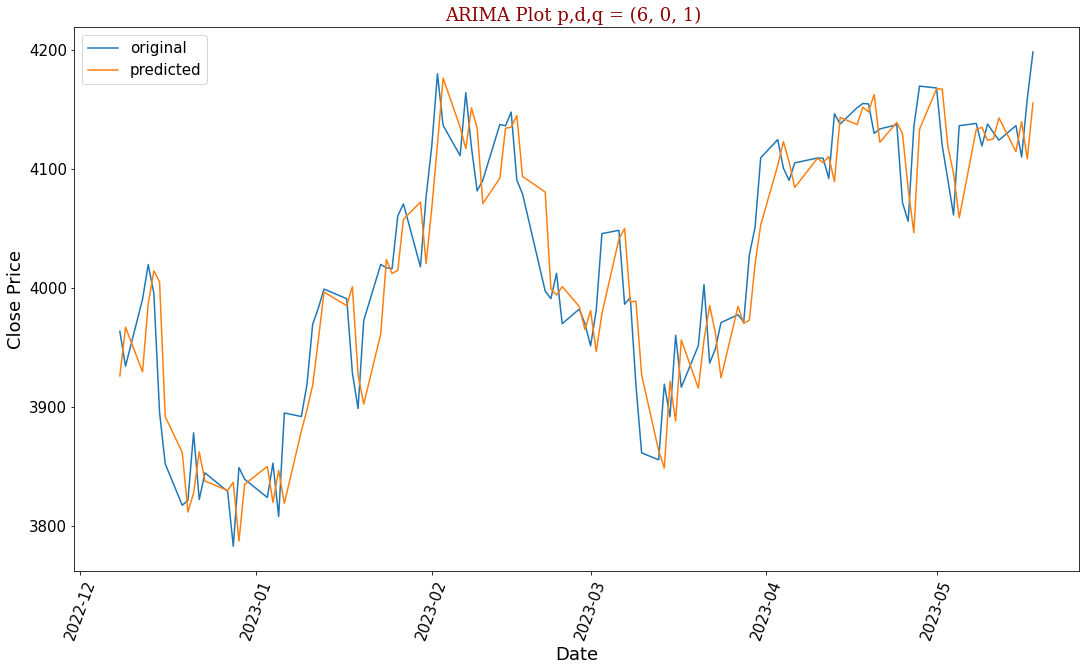

       mape        me         mae       mpe        rmse
0  0.030278 -3.325772  121.269134 -0.000112  150.386825


In [201]:
pdq = 6,0,1
train, test, predictions, acc = ARIMA_model_fit_plot(df, pdq, 0.9)
# print(train)
# print(test)
# print(predictions)
print(acc)

In [158]:
df

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2023-05-12,4124.08
2023-05-15,4136.28
2023-05-16,4109.90
